In [3]:
import sqlite3
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

conn = sqlite3.connect('/Users/miguelbandeira/Desktop/Faculdade/Mestrado/1º ano/2º semestre - Erasmus/Fundamentals of Data Science/Project/database.sqlite')
countries = pd.read_sql_query("SELECT * from Country", conn)
leagues = pd.read_sql_query("SELECT * from League", conn)
teams = pd.read_sql_query("SELECT * from Team", conn)
tempmatch = pd.read_sql_query("SELECT * from Match", conn)
team_att = pd.read_sql_query("SELECT * from Team_Attributes", conn)

In [4]:
print(countries.shape)
print(tempmatch.shape)
print(leagues.shape)
print(teams.shape)
print(team_att.shape)
print(leagues.shape)

(11, 2)
(25979, 115)
(11, 3)
(299, 5)
(1458, 25)
(11, 3)


In [612]:
tempmatch.columns

Index(['home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'date', 'home_team_result', 'away_team_result',
       'home_last_wins', 'away_last_wins', 'home_eachother_wins',
       'last_wins_diff'],
      dtype='object')

In [613]:
tempmatch.isna().sum()

home_team_api_id       0
away_team_api_id       0
home_team_goal         0
away_team_goal         0
date                   0
home_team_result       0
away_team_result       0
home_last_wins         0
away_last_wins         0
home_eachother_wins    0
last_wins_diff         0
dtype: int64

In [5]:
query_matches = 'select match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, date from Match where league_id = 17642;'
matches = pd.read_sql(query_matches, conn, index_col='match_api_id', parse_dates=['date']);
matches.isna().sum()
matches.describe()

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
count,2052.000000,2052.000000,2052.000000,2052.000000
mean,13952.262671,13952.262671,1.408382,1.126218
std,27856.758697,27856.758697,1.226192,1.155469
min,2033.000000,2033.000000,0.000000,0.000000
25%,7844.000000,7844.000000,0.000000,0.000000
50%,9772.000000,9772.000000,1.000000,1.000000
75%,10214.000000,10214.000000,2.000000,2.000000
max,188163.000000,188163.000000,8.000000,6.000000


In [6]:
def teamattrs(team_api_id, matchdate):

    query_attrs ='select date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression, defenceTeamWidth from Team_Attributes where team_api_id = %s order by date asc;' % team_api_id
    attrs = pd.read_sql(query_attrs, conn, parse_dates=['date'])
    if (not attrs.empty):
        closestattrs = None
        mindiff = None
        for index, row in attrs.iterrows():
            date = row['date']
            diff = abs(matchdate - date)
            if (mindiff is None or diff < mindiff):
                mindiff = diff
                closestattrs = row
        return closestattrs.drop('date')
    else:
        return None

def result_home(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

def result_away(row):
    if row['away_team_goal'] == row['home_team_goal']:
        val = 0
    elif row['away_team_goal'] > row['home_team_goal']:
        val = 1
    else:
        val = -1
    return val

matches["home_team_result"] = matches.apply(result_home,axis = 1)
matches["away_team_result"] = matches.apply(result_away,axis = 1)
matches

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result
match_api_id,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1
509130,9768,7992,3,1,2008-08-23,1,-1
509131,7844,10238,1,1,2008-08-22,0,0
509132,6403,10264,0,2,2008-08-23,-1,1
509133,10213,10215,1,0,2008-08-24,1,-1
...,...,...,...,...,...,...,...
2015885,10264,9807,4,0,2015-10-31,1,-1
2015886,188163,9772,0,4,2015-10-30,-1,1
2015887,9768,7842,1,0,2015-10-31,1,-1


In [616]:
nulls = matches.isna().sum()
nulls

home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
date                0
home_team_result    0
away_team_result    0
dtype: int64

In [7]:
def get_last_matches(matches, date, team, x):

    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    return last_matches

def get_last_matches_against_eachother(matches, date, home_team, away_team, x):

    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    return last_matches

def get_wins(matches, team):

    home_wins = int(matches.home_team_result[(matches.home_team_api_id == team) & (matches.home_team_result == 1)].count())
    away_wins = int(matches.away_team_result[(matches.away_team_api_id == team) & (matches.away_team_result == 1)].count())

    total_wins = home_wins + away_wins

    return total_wins      

def create_home_last_wins(row):
    date = row['date']
    home_team = row['home_team_api_id']
    home_last_matches = get_last_matches(matches, date, home_team, 10)
    home_last_matches_wins = get_wins(home_last_matches, home_team)
    return home_last_matches_wins

def create_away_last_wins(row):
    date = row['date']
    away_team = row['away_team_api_id']
    away_last_matches = get_last_matches(matches, date, away_team, 10)
    away_last_matches_wins = get_wins(away_last_matches, away_team)
    return away_last_matches_wins

def create_home_eachother_wins(row):
    date = row['date']
    home_team = row['home_team_api_id']
    away_team = matches['away_team_api_id']
    last_matches_eachother = get_last_matches_against_eachother(matches, date, home_team, away_team, 10)
    last_matches_eachother_home_win = get_wins(last_matches_eachother, home_team)
    return last_matches_eachother_home_win


In [8]:
matches['home_last_wins'] = matches.apply (lambda row: create_home_last_wins(row), axis=1)
matches.head(20)

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins
match_api_id,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0
509130,9768,7992,3,1,2008-08-23,1,-1,0
509131,7844,10238,1,1,2008-08-22,0,0,0
509132,6403,10264,0,2,2008-08-23,-1,1,0
509133,10213,10215,1,0,2008-08-24,1,-1,0
509134,7841,9772,1,1,2008-08-24,0,0,0
509135,6421,10214,1,3,2008-08-24,-1,1,0
509136,9809,10212,1,0,2008-08-24,1,-1,0
509201,9773,10215,2,1,2008-12-01,1,-1,4


In [9]:
matches['away_last_wins'] = matches.apply (lambda row: create_away_last_wins(row), axis=1)
matches.head(20)

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins,away_last_wins
match_api_id,,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0,0
509130,9768,7992,3,1,2008-08-23,1,-1,0,0
509131,7844,10238,1,1,2008-08-22,0,0,0,0
509132,6403,10264,0,2,2008-08-23,-1,1,0,0
509133,10213,10215,1,0,2008-08-24,1,-1,0,0
509134,7841,9772,1,1,2008-08-24,0,0,0,0
509135,6421,10214,1,3,2008-08-24,-1,1,0,0
509136,9809,10212,1,0,2008-08-24,1,-1,0,0
509201,9773,10215,2,1,2008-12-01,1,-1,4,2


In [10]:
matches['home_eachother_wins'] = matches.apply(lambda row: create_home_eachother_wins(row), axis=1)
matches.head(10)

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins,away_last_wins,home_eachother_wins
match_api_id,,,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0,0,0
509130,9768,7992,3,1,2008-08-23,1,-1,0,0,0
509131,7844,10238,1,1,2008-08-22,0,0,0,0,0
509132,6403,10264,0,2,2008-08-23,-1,1,0,0,0
509133,10213,10215,1,0,2008-08-24,1,-1,0,0,0
509134,7841,9772,1,1,2008-08-24,0,0,0,0,0
509135,6421,10214,1,3,2008-08-24,-1,1,0,0,0
509136,9809,10212,1,0,2008-08-24,1,-1,0,0,0
509201,9773,10215,2,1,2008-12-01,1,-1,4,2,3


In [11]:
matches['last_wins_diff'] = matches['home_last_wins'] - matches['away_last_wins']
matches.head(10)

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins,away_last_wins,home_eachother_wins,last_wins_diff
match_api_id,,,,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0,0,0,0
509130,9768,7992,3,1,2008-08-23,1,-1,0,0,0,0
509131,7844,10238,1,1,2008-08-22,0,0,0,0,0,0
509132,6403,10264,0,2,2008-08-23,-1,1,0,0,0,0
509133,10213,10215,1,0,2008-08-24,1,-1,0,0,0,0
509134,7841,9772,1,1,2008-08-24,0,0,0,0,0,0
509135,6421,10214,1,3,2008-08-24,-1,1,0,0,0,0
509136,9809,10212,1,0,2008-08-24,1,-1,0,0,0,0
509201,9773,10215,2,1,2008-12-01,1,-1,4,2,3,2


In [53]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression


In [ ]:

target = matches[['home_team_result']]
features = matches[['home_eachother_wins', 'last_wins_diff']]
X_train,X_test,y_train,y_test = train_test_split(features, target, test_size=0.2, stratify = target)

In [623]:
names = ["Nearest Neighbors", "Logistic Regression",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(100),
    LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced'),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced'),
    AdaBoostClassifier(n_estimators = 200, random_state = 2),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print(name, accuracy_score(y_test, clf.predict(X_test)))

Nearest Neighbors 0.4768856447688564
Logistic Regression 0.5109489051094891
Decision Tree 0.49391727493917276
Random Forest 0.44038929440389296
Neural Net 0.49878345498783455
AdaBoost 0.5060827250608273
Naive Bayes 0.49878345498783455


In [12]:
def get_home_attrs(row):
    date = row['date']
    homeattrs = teamattrs(row['home_team_api_id'], date)
    return homeattrs

In [13]:
def get_away_attrs(row):
    date = row['date']
    awayattrs = teamattrs(row['away_team_api_id'], date)
    return awayattrs

In [14]:
homeattrs = matches.apply(get_home_attrs, axis=1).dropna(axis=0, how='any')
homeattrs.rename(columns={'buildUpPlaySpeed':'home_buildUpPlaySpeed', 'buildUpPlayPassing':'home_buildUpPlayPassing', 'chanceCreationPassing':'home_chanceCreationPassing', 'chanceCreationCrossing':'home_chanceCreationCrossing', 'chanceCreationShooting':'home_chanceCreationShooting', 'defencePressure':'home_defencePressure', 'defenceAggression':'home_defenceAggression','defenceTeamWidth':'home_defenceTeamWidth'}, inplace=True)
homeattrs

,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth
match_api_id,,,,,,,,
509129,30.0,30.0,60.0,60.0,60.0,30.0,30.0,30.0
509130,30.0,30.0,55.0,60.0,55.0,30.0,30.0,30.0
509131,30.0,30.0,55.0,55.0,55.0,30.0,30.0,30.0
509132,30.0,30.0,50.0,60.0,60.0,30.0,30.0,30.0
509134,30.0,30.0,45.0,55.0,60.0,30.0,30.0,30.0
...,...,...,...,...,...,...,...,...
2015883,63.0,39.0,64.0,53.0,52.0,36.0,39.0,64.0
2015884,58.0,42.0,54.0,52.0,52.0,37.0,37.0,58.0
2015885,55.0,55.0,62.0,65.0,39.0,25.0,56.0,39.0


In [15]:
awayattrs = matches.apply(get_away_attrs, axis=1).dropna(axis=0, how='any')
awayattrs.rename(columns={'buildUpPlaySpeed':'away_buildUpPlaySpeed', 'buildUpPlayPassing':'away_buildUpPlayPassing', 'chanceCreationPassing':'away_chanceCreationPassing', 'chanceCreationCrossing':'away_chanceCreationCrossing', 'chanceCreationShooting':'away_chanceCreationShooting', 'defencePressure':'away_defencePressure', 'defenceAggression':'away_defenceAggression','defenceTeamWidth':'away_defenceTeamWidth'}, inplace=True)
awayattrs

,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
match_api_id,,,,,,,,
509129,30.0,30.0,55.0,45.0,60.0,30.0,30.0,30.0
509131,30.0,30.0,60.0,50.0,55.0,30.0,30.0,30.0
509132,30.0,30.0,55.0,50.0,60.0,30.0,30.0,30.0
509133,30.0,30.0,50.0,60.0,55.0,30.0,30.0,30.0
509134,30.0,30.0,50.0,55.0,65.0,30.0,30.0,30.0
...,...,...,...,...,...,...,...,...
2015885,51.0,52.0,43.0,37.0,48.0,38.0,48.0,49.0
2015886,69.0,53.0,65.0,66.0,54.0,60.0,57.0,54.0
2015887,59.0,52.0,47.0,53.0,39.0,46.0,49.0,55.0


In [16]:
matches_att = pd.merge(left=homeattrs, right=awayattrs, how='left', left_on='match_api_id', right_on='match_api_id')
matches_att

,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
match_api_id,,,,,,,,,,,,,,,,
509129,30.0,30.0,60.0,60.0,60.0,30.0,30.0,30.0,30.0,30.0,55.0,45.0,60.0,30.0,30.0,30.0
509130,30.0,30.0,55.0,60.0,55.0,30.0,30.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509131,30.0,30.0,55.0,55.0,55.0,30.0,30.0,30.0,30.0,30.0,60.0,50.0,55.0,30.0,30.0,30.0
509132,30.0,30.0,50.0,60.0,60.0,30.0,30.0,30.0,30.0,30.0,55.0,50.0,60.0,30.0,30.0,30.0
509134,30.0,30.0,45.0,55.0,60.0,30.0,30.0,30.0,30.0,30.0,50.0,55.0,65.0,30.0,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015883,63.0,39.0,64.0,53.0,52.0,36.0,39.0,64.0,40.0,39.0,53.0,62.0,58.0,37.0,40.0,64.0
2015884,58.0,42.0,54.0,52.0,52.0,37.0,37.0,58.0,65.0,39.0,55.0,59.0,46.0,37.0,39.0,37.0
2015885,55.0,55.0,62.0,65.0,39.0,25.0,56.0,39.0,51.0,52.0,43.0,37.0,48.0,38.0,48.0,49.0


In [17]:
matches_att['buildUpPlaySpeed_diff'] = matches_att['home_buildUpPlaySpeed'] - matches_att['away_buildUpPlaySpeed']
matches_att['buildUpPlayPassing_diff'] = matches_att['home_buildUpPlayPassing'] - matches_att['away_buildUpPlayPassing']
matches_att['chanceCreationPassing_diff'] = matches_att['home_chanceCreationPassing'] - matches_att['away_chanceCreationPassing']
matches_att['chanceCreationCrossing_diff'] = matches_att['home_chanceCreationCrossing'] - matches_att['away_chanceCreationCrossing']
matches_att['chanceCreationShooting_diff'] = matches_att['home_chanceCreationShooting'] - matches_att['away_chanceCreationShooting']
matches_att['defencePressure_diff'] = matches_att['home_defencePressure'] - matches_att['away_defencePressure']
matches_att['defenceAggression_diff'] = matches_att['home_defenceAggression'] - matches_att['away_defenceAggression']
matches_att['defenceTeamWidth_diff'] = matches_att['home_defenceTeamWidth'] - matches_att['away_defenceTeamWidth']
matches_att

,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,...,away_defenceAggression,away_defenceTeamWidth,buildUpPlaySpeed_diff,buildUpPlayPassing_diff,chanceCreationPassing_diff,chanceCreationCrossing_diff,chanceCreationShooting_diff,defencePressure_diff,defenceAggression_diff,defenceTeamWidth_diff
match_api_id,,,,,,,,,,,,,,,,,,,,,
509129,30.0,30.0,60.0,60.0,60.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,0.0,0.0,5.0,15.0,0.0,0.0,0.0,0.0
509130,30.0,30.0,55.0,60.0,55.0,30.0,30.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509131,30.0,30.0,55.0,55.0,55.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,0.0,0.0,-5.0,5.0,0.0,0.0,0.0,0.0
509132,30.0,30.0,50.0,60.0,60.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,0.0,0.0,-5.0,10.0,0.0,0.0,0.0,0.0
509134,30.0,30.0,45.0,55.0,60.0,30.0,30.0,30.0,30.0,30.0,...,30.0,30.0,0.0,0.0,-5.0,0.0,-5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015883,63.0,39.0,64.0,53.0,52.0,36.0,39.0,64.0,40.0,39.0,...,40.0,64.0,23.0,0.0,11.0,-9.0,-6.0,-1.0,-1.0,0.0
2015884,58.0,42.0,54.0,52.0,52.0,37.0,37.0,58.0,65.0,39.0,...,39.0,37.0,-7.0,3.0,-1.0,-7.0,6.0,0.0,-2.0,21.0
2015885,55.0,55.0,62.0,65.0,39.0,25.0,56.0,39.0,51.0,52.0,...,48.0,49.0,4.0,3.0,19.0,28.0,-9.0,-13.0,8.0,-10.0


In [18]:
final_matches = pd.merge(left=matches, right=matches_att, how='left', left_on='match_api_id', right_on='match_api_id')
final_matches

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins,away_last_wins,home_eachother_wins,...,away_defenceAggression,away_defenceTeamWidth,buildUpPlaySpeed_diff,buildUpPlayPassing_diff,chanceCreationPassing_diff,chanceCreationCrossing_diff,chanceCreationShooting_diff,defencePressure_diff,defenceAggression_diff,defenceTeamWidth_diff
match_api_id,,,,,,,,,,,,,,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0,0,0,...,30.0,30.0,0.0,0.0,5.0,15.0,0.0,0.0,0.0,0.0
509130,9768,7992,3,1,2008-08-23,1,-1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509131,7844,10238,1,1,2008-08-22,0,0,0,0,0,...,30.0,30.0,0.0,0.0,-5.0,5.0,0.0,0.0,0.0,0.0
509132,6403,10264,0,2,2008-08-23,-1,1,0,0,0,...,30.0,30.0,0.0,0.0,-5.0,10.0,0.0,0.0,0.0,0.0
509133,10213,10215,1,0,2008-08-24,1,-1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015885,10264,9807,4,0,2015-10-31,1,-1,5,3,5,...,48.0,49.0,4.0,3.0,19.0,28.0,-9.0,-13.0,8.0,-10.0
2015886,188163,9772,0,4,2015-10-30,-1,1,1,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015887,9768,7842,1,0,2015-10-31,1,-1,8,5,8,...,49.0,55.0,-2.0,4.0,-5.0,-3.0,16.0,14.0,11.0,-1.0


In [19]:
final_matches = final_matches.drop(['home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing', 'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure', 'home_defenceAggression', 'home_defenceTeamWidth', 'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing', 'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure', 'away_defenceAggression', 'away_defenceTeamWidth'], axis=1)

In [20]:
final_matches = final_matches.dropna()
nulls = final_matches.isna().sum()
nulls

home_team_api_id               0
away_team_api_id               0
home_team_goal                 0
away_team_goal                 0
date                           0
home_team_result               0
away_team_result               0
home_last_wins                 0
away_last_wins                 0
home_eachother_wins            0
last_wins_diff                 0
buildUpPlaySpeed_diff          0
buildUpPlayPassing_diff        0
chanceCreationPassing_diff     0
chanceCreationCrossing_diff    0
chanceCreationShooting_diff    0
defencePressure_diff           0
defenceAggression_diff         0
defenceTeamWidth_diff          0
dtype: int64

In [21]:
final_matches

,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,date,home_team_result,away_team_result,home_last_wins,away_last_wins,home_eachother_wins,last_wins_diff,buildUpPlaySpeed_diff,buildUpPlayPassing_diff,chanceCreationPassing_diff,chanceCreationCrossing_diff,chanceCreationShooting_diff,defencePressure_diff,defenceAggression_diff,defenceTeamWidth_diff
match_api_id,,,,,,,,,,,,,,,,,,,
509129,9773,9807,2,0,2008-08-24,1,-1,0,0,0,0,0.0,0.0,5.0,15.0,0.0,0.0,0.0,0.0
509131,7844,10238,1,1,2008-08-22,0,0,0,0,0,0,0.0,0.0,-5.0,5.0,0.0,0.0,0.0,0.0
509132,6403,10264,0,2,2008-08-23,-1,1,0,0,0,0,0.0,0.0,-5.0,10.0,0.0,0.0,0.0,0.0
509134,7841,9772,1,1,2008-08-24,0,0,0,0,0,0,0.0,0.0,-5.0,0.0,-5.0,0.0,0.0,0.0
509135,6421,10214,1,3,2008-08-24,-1,1,0,0,0,0,-15.0,0.0,-10.0,-5.0,15.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015883,6403,7844,0,1,2015-11-02,-1,1,5,2,4,3,23.0,0.0,11.0,-9.0,-6.0,-1.0,-1.0,0.0
2015884,10238,158085,0,0,2015-11-01,0,0,4,2,2,2,-7.0,3.0,-1.0,-7.0,6.0,0.0,-2.0,21.0
2015885,10264,9807,4,0,2015-10-31,1,-1,5,3,5,2,4.0,3.0,19.0,28.0,-9.0,-13.0,8.0,-10.0


In [31]:
target = final_matches[['home_team_result']]
features = final_matches[['buildUpPlaySpeed_diff', 'buildUpPlayPassing_diff', 'chanceCreationPassing_diff', 'chanceCreationCrossing_diff', 'chanceCreationShooting_diff', 'defencePressure_diff', 'defenceAggression_diff', 'defenceTeamWidth_diff']]
X_train,X_test,y_train,y_test = train_test_split(features, target, test_size=0.2, stratify = target)

In [32]:
names = ["Nearest Neighbors", "Logistic Regression",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced'),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced'),
    AdaBoostClassifier(n_estimators = 200, random_state = 2),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print(name, accuracy_score(y_test, clf.predict(X_test)))

Nearest Neighbors 0.4572192513368984
Logistic Regression 0.4893048128342246
Decision Tree 0.4893048128342246
Random Forest 0.44385026737967914
Neural Net 0.49732620320855614
AdaBoost 0.5267379679144385
Naive Bayes 0.5080213903743316


In [50]:
target = final_matches[['home_team_result']]
features = final_matches[['buildUpPlaySpeed_diff', 'buildUpPlayPassing_diff', 'chanceCreationPassing_diff', 'chanceCreationCrossing_diff', 'chanceCreationShooting_diff', 'defencePressure_diff', 'defenceAggression_diff', 'defenceTeamWidth_diff','home_eachother_wins', 'last_wins_diff']]
X_train,X_test,y_train,y_test = train_test_split(features, target, test_size=0.2, stratify = target)

Nearest Neighbors 0.47058823529411764
Logistic Regression 0.5508021390374331
Decision Tree 0.4679144385026738
Random Forest 0.4839572192513369
Neural Net 0.48663101604278075
AdaBoost 0.5294117647058824
Naive Bayes 0.5080213903743316


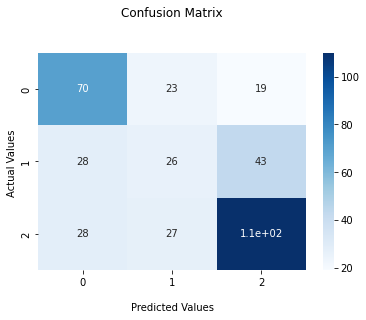

In [57]:
names = ["Nearest Neighbors", "Logistic Regression",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced'),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced'),
    AdaBoostClassifier(n_estimators = 200, random_state = 2),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        if(name == "Logistic Regression"):
            cf_matrix = confusion_matrix(y_test, pred)

            ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
            ax.set_title('Confusion Matrix\n\n');
            ax.set_xlabel('\nPredicted Values')
            ax.set_ylabel('Actual Values ');

        print(name, accuracy_score(y_test, pred))